# Transfer Learning from PatchCore to Linear Regression
The following document will attempt a solutiont to abstract PatchCore away in order to hide the memory bank.  
By hiding the memory bank, we become able to use HomoMorphic Encryption on the model.

**This document follows these steps:**
1. Train PatchCore on half the dataset **dataset_a** -> result: patchCore model (**ModelA**)
2. Evaluate the resulting model (we care about AUROC)
3. Use **modelA** to add labels (*anomaly scores*)to all patches within the images in **dataset_b** -> **annotated_dataset_b**.
4. Use annotated_dataset_b to train a LinearRegression model **ModelB**
5. With ModelB, estimate patch scores for test data patches.
6. Test the model effictiveness of ModelB.
7. Conclusion on the performance of ModelB

## (1) Training PatchCore

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pytorch_lightning import Trainer, seed_everything

from config import get_configurable_parameters
from data import get_datamodule
from models import get_model
from utils.callbacks import LoadModelCallback, get_callbacks

# config
config = get_configurable_parameters(model_name="patchcore", config_path="config.yaml")
if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

# prepare dataomdule
datamodule = get_datamodule(config)

# prepare model
model = get_model(config)
callbacks = get_callbacks(config)

# fit the model
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PatchcoreModel           | 24.9 M
3 | image_metrics         | AnomalibMetric

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## (2) Evaluate the resulting model model_a

In [3]:
trainer.test(model=model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9715957045555115
       pixel_AUROC          0.9759382605552673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_AUROC': 0.9759382605552673, 'image_AUROC': 0.9715957045555115}]

## (3) Preprocessing: Annotate dataset_b

In [4]:
import json
import torch
from typing import List

from inferencer import TorchInferencer
from data.utils import get_image_filenames, read_image


inferencer = TorchInferencer(
    config=config,
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
    device="auto"
)
model = inferencer.model.model
filenames = get_image_filenames(path="datasets/MVTec_b/grid/")

def generate_embeddings(filenames: List[str]):  #  -> Tuple(List[patches], List[patchScores])
    embeddings = []
    outputs = []
    print("Preparing data for training by generating embeddings")
    for i, filename in enumerate(filenames):
        image_arr = read_image(filename)
        metadata = inferencer.metadata
        metadata["image_shape"] = image_arr.shape[:2]
        processed_image = inferencer.pre_process(image_arr)
    
        # generating embeddings
        with torch.no_grad():
            features = model.feature_extractor(processed_image)
        features = {layer: model.feature_pooler(feature) for layer, feature in features.items()}
        embedding = model.generate_embedding(features)
        batch_size, _, width, height = embedding.shape
        embedding = model.reshape_embedding(embedding)

        embeddings += embedding.tolist()

        # calculating anomaly score / patch
        outputs += model.nearest_neighbors(embedding=embedding, n_neighbors=1)[0].tolist()

        if (i + 1) % 25 == 0:
            print(f"Finished {i + 1} out of {len(filenames)} images")

    print("Finished all!")
    return embeddings, outputs

## (4) Train the LR model

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [39]:
# preparing training dataset
# we use dataset_b + a percentage of the test dataset.

test_images_used_for_training, test_images_used_for_test = train_test_split(
    get_image_filenames("datasets/MVTec_b/grid/test"),
    test_size=0.35, random_state=4
)
training_images =  get_image_filenames("datasets/MVTec_b/grid/train") + test_images_used_for_training
train_data, train_data_output = generate_embeddings(training_images)

# preparing test dataset
test_data, test_data_output = generate_embeddings(test_images_used_for_test)

Preparing data for training by generating embeddings
Finished 25 out of 181 images
Finished 50 out of 181 images
Finished 75 out of 181 images
Finished 100 out of 181 images
Finished 125 out of 181 images
Finished 150 out of 181 images
Finished 175 out of 181 images
Finished all!
Preparing data for training by generating embeddings
Finished 25 out of 28 images
Finished all!


In [40]:
import time

s = time.time()

# training the model
lr_model = LinearRegression()
lr_model.fit(train_data,train_data_output)

print(f"Took {int((time.time() - s) / 60)} minutes")

Took 38 minutes


## (5) Evaluating the LR model on input data

In [45]:
# Simple evaluation of the model
from sklearn.metrics import r2_score, mean_squared_error

# Compute R-squared and RMSE scores for training data
train_predicted = lr_model.predict(train_data)
r2 = r2_score(train_data_output, train_predicted)
print('Train R-squared score: ', r2)
rmse = mean_squared_error(train_data_output, train_predicted, squared=False)
print(f"Train RMSE: {rmse}")

# Compute R-squared and RMSE scores for test data
test_predicted = lr_model.predict(test_data)
r2 = r2_score(test_data_output, test_predicted)
print('Test R-squared score: ', r2)
rmse = mean_squared_error(test_data_output, test_predicted, squared=False)
print(f"Test RMSE: {rmse}")

Train R-squared score:  0.761073542732323
Train RMSE: 1.8772224885742783
Test R-squared score:  0.5823333557861581
Test RMSE: 3.0255061258495606


#### Other test results
For 20% data used for test, we got these results:

Train R-squared score:  0.7634848711779179  
Train RMSE: 1.9009882852371975  
Test R-squared score:  0.7087589398384689  
Test RMSE: 2.5287173684712343

For 40$ data used for test:

Train R-squared score:  0.7580124721150889  
Train RMSE: 1.8707663855205992  
Test R-squared score:  0.269349455405679  
Test RMSE: 4.07187818497981

## (6) Testing PatchCore anomaly scoring performance against our new linear regression model

### Steps 
1. Prepare the dataset to be used. This is a list of embeddings for all images in the dataset
2. Run PatchCore on the given dataset and store the resulting patch score values in an array
3. Run the same dataset on the LR model, and store the results
4. Plot both numbers against each other

Question: What exactly should we plot?
We need a good metric to measure the deviation of the LR results from the patchCore results.

In [46]:
## step1 - prepare the test dataset
import torch

from data.utils import get_image_filenames, read_image
from inferencer import TorchInferencer
from post_processing import Visualizer


inferencer = TorchInferencer(
    config="config.yaml",
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
)
patchcore_model = inferencer.model.model

metadata = getattr(inferencer, "metadata")

embeddings = []
for filename in test_images_used_for_test:
    image_arr=read_image(filename)
    metadata["image_shape"] = image_arr.shape[:2]

    processed_image = inferencer.pre_process(image_arr)

    with torch.no_grad():
        features = patchcore_model.feature_extractor(processed_image)  # 2nd and 3rd layer
    
    features = {layer: patchcore_model.feature_pooler(feature) for layer, feature in features.items()}
    embedding = patchcore_model.generate_embedding(features)

    batch_size, _, width, height = embedding.shape
    embedding = patchcore_model.reshape_embedding(embedding)
    embeddings.append(embedding)

len(embeddings)

28

In [47]:
## step 2 - patch score results
### patchcore results for the given 78 images flattened
patchcore_results = []
for embedding in embeddings:
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_results += patch_scores_patchcore
len(patchcore_results)

21952

In [48]:
## step 3 - LR results
### LR model results for the given 78 images
lr_results = []
for embedding in embeddings:
    patch_scores_lr_model = lr_model.predict(embedding).tolist()
    lr_results += patch_scores_lr_model
len(lr_results)

21952

In [49]:
import matplotlib.pyplot as plt


def draw_two_plots(y1, y2, x_axis="Patch Index", y_axis="Anomaly Score", title="PatchCore vs LinearRegression"):
    fig, ax = plt.subplots()
    
    ax.plot(y1, color='red', label="patchCore")
    ax.plot(y2, color='blue', label="Linear Regression")
    
    # Add labels and title
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_title(title)
    ax.legend()
    plt.show()

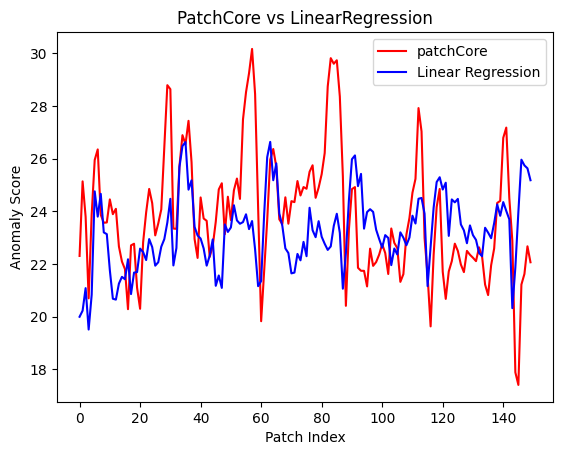

In [50]:
draw_two_plots(patchcore_results[11000:11150], lr_results[11000:11150])


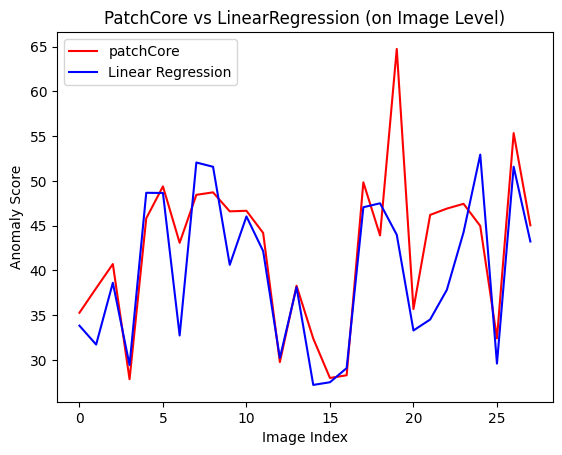

In [51]:
# Measuring the image-level anomaly scores deviation

patchcore_image_results = []
for embedding in embeddings:  # We use the Max function to determine the image patch score
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_image_results.append(max(patch_scores_patchcore))
len(patchcore_image_results)

lr_image_results = []
for embedding in embeddings:
    patch_scores_lr_model = lr_model.predict(embedding).tolist()
    lr_image_results.append(max(patch_scores_lr_model))
len(lr_image_results)

draw_two_plots(patchcore_image_results, lr_image_results, x_axis="Image Index", title='PatchCore vs LinearRegression (on Image Level)')

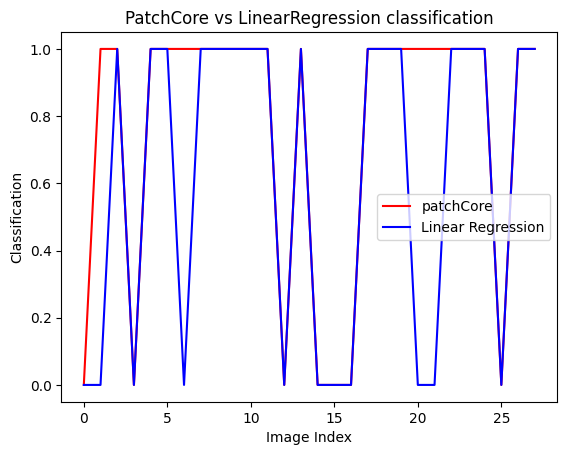

In [59]:
# Measuring the image-level classification deviation
threshold = inferencer.metadata["image_threshold"]

patchcore_image_results_class = [1 if res > threshold else 0 for res in patchcore_image_results]
lr_image_results_class        = [1 if res > threshold else 0 for res in lr_image_results]

draw_two_plots(patchcore_image_results_class, lr_image_results_class, x_axis="Image Index", y_axis="Classification", title='PatchCore vs LinearRegression classification')

In [63]:
sum(patchcore_image_results_class), sum(lr_image_results_class)

(21, 17)

## Conclusion

The Linear Regression model doesn't do a good job following the PatchCore results.

Adjusting the threshold might be a good way to improve the model,  
but given that the difference between the two models is not a linear bias, we can assume that changing the threshold will not give us a perfect model. 

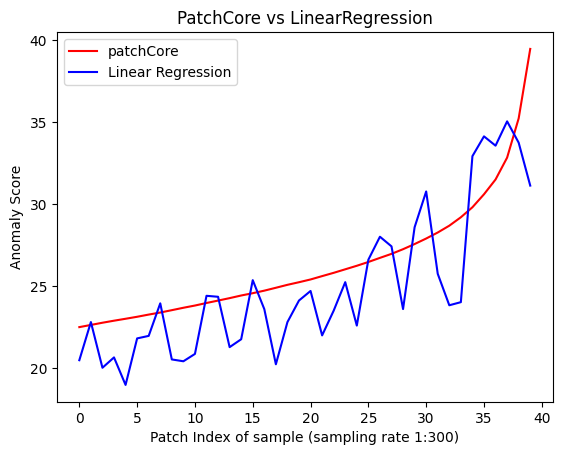

In [62]:
# Clearly show the deviation by ordering the patchCore results by lowest to highest

# this line creates a list of pairs of (patchcore result, LR result) for each patch
y12 = [(patchcore_results[i], lr_results[i]) for i in range(len(patchcore_results))]

# we sort by patchcore result from lowest to highest - while keeping the second element to the LR value
y12 = sorted(y12, key=lambda x: x[0])

# we split again patchcore (y1) from Linear Regression (y2) so we can plot them
y1 = [x[0] for x in y12]
y2 = [x[1] for x in y12]
draw_two_plots(y1[10000::300], y2[10000::300], x_axis="Patch Index of sample (sampling rate 1:300)")

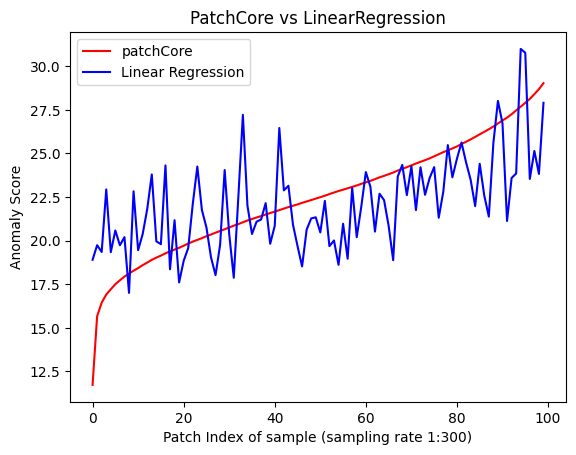

In [55]:
# Drawing 200 patch scores samples at 1/20 (we present 1 then skip 19, for 100 times)
draw_two_plots(y1[0:20000:200], y2[0:20000:200], x_axis="Patch Index of sample (sampling rate 1:300)")

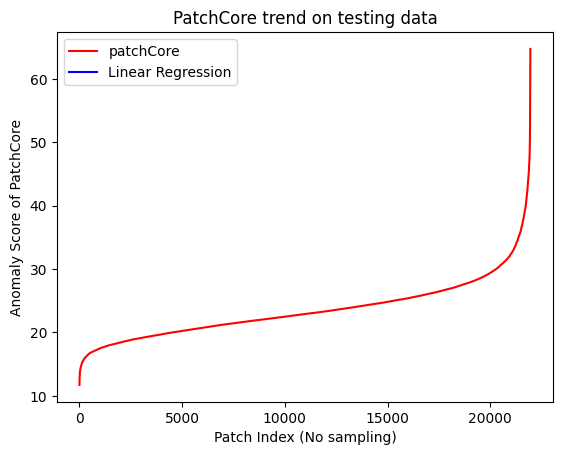

In [56]:
# This graph should give an insight on the distribution of anomaly scores on the test dataset. 

draw_two_plots(y1, [], x_axis="Patch Index (No sampling)", y_axis="Anomaly Score of PatchCore", title="PatchCore trend on testing data")

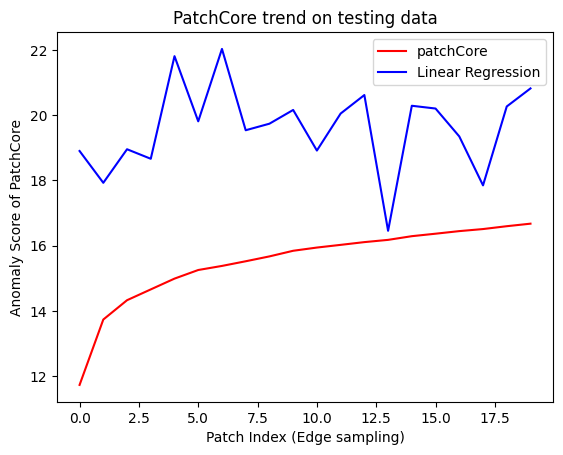

In [57]:
# out of curiousity, let's also see how the MLP model follows PatchCore on the boundaries and the middle sections

y1_boundaries = y1[:500:25] + y1[27652::125]  # 20 samples out of the first 500 points
y2_boundaries = y2[:500:25] + y2[27652::125]  # 20 samples out of the last 2500 points

draw_two_plots(y1_boundaries, y2_boundaries, x_axis="Patch Index (Edge sampling)", y_axis="Anomaly Score of PatchCore", title="PatchCore trend on testing data")

In [66]:
label_converter = lambda label_list: list(map(lambda x: 0 if x else 1, label_list))


In [67]:
label_converter([True, False])

[0, 1]